# Importing Lib



In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

2025-04-14 06:39:18.499899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744612758.855235      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744612758.952250      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [4]:
data = pd.read_csv('/kaggle/input/gps-uav/ALL_FAIL_LOG_GPS_0_Add_Num_Random.csv')


# Preprocessing and Exploring data



In [5]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())


Dataset Shape: (4319, 17)

Columns:
 Index(['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U', 'labels'],
      dtype='object')

Sample Data:
    LineNo     TimeUS  I  Status        GMS   GWk  NSats  HDop        Lat  \
0  186120  238603687  0       6  547888600  2232     10  1.21 -35.360988   
1   70202  109203801  0       1  547759200  2232      3  1.21 -35.362661   
2   37211   72603447  0       6  547722600  2232     10  1.21 -35.363286   
3  426537  505803431  0       6  548155800  2232     10  1.21 -35.363284   
4  319397  386803550  0       6  548036800  2232     10  1.21 -35.361890   

          Lng    Alt    Spd       GCrs     VZ  Yaw  U  labels  
0  149.163326  48.64  1.700   29.63562 -1.197    0  1       0  
1  149.162593  39.94  3.885  327.20960  0.031    0  1       1  
2  149.163059  39.94  0.025  303.80130 -0.009    0  1       0  
3  149.163061  20.39  0.000  258.62220  0.000    0  1       4  
4  1

In [6]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo      int64
TimeUS      int64
I           int64
Status      int64
GMS         int64
GWk         int64
NSats       int64
HDop      float64
Lat       float64
Lng       float64
Alt       float64
Spd       float64
GCrs      float64
VZ        float64
Yaw         int64
U           int64
labels      int64
dtype: object


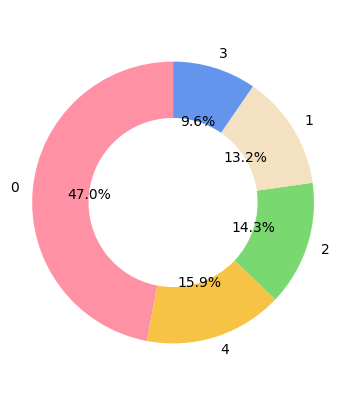

In [7]:

if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    # Define specific colors for 5 labels
    colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]

    # Plot the donut chart
    plt.figure(figsize=(4, 5))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'width': 0.4})
    plt.axis('equal')
    plt.show()



In [8]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [9]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [10]:
X.shape

(4319, 16)

In [11]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [13]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [14]:
X_reshaped.shape

(4319, 1, 16)

# Model

In [15]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [16]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [17]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    # inputs = Input(shape=input_shape)
# def build_tcn_attention_model(X_reshaped, num_classes):
    inputs = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
     # Replacing input_shape with X_reshaped.shape
    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model


In [18]:
# input_shape
X_reshaped.shape[2]

16

In [19]:
X_reshaped.shape[1]

1

In [20]:
X_reshaped.shape[0]

4319

In [21]:
X_reshaped.shape

(4319, 1, 16)

In [22]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [23]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuraciesKF = []
label_accuraciesKF = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_foldKF, X_val_foldKF = X_reshaped[train_index], X_reshaped[val_index]
    y_train_foldKF, y_val_foldKF = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    # modelKF = build_tcn_attention_model(input_shape, num_classes)
    modelKF = build_tcn_attention_model(X_reshaped, num_classes)
    modelKF.fit(X_train_foldKF, y_train_foldKF, epochs=50, batch_size=32, verbose=0, validation_data=(X_val_foldKF, y_val_foldKF))

    # Evaluate the model
    lossKF, accuracyKF = modelKF.evaluate(X_val_foldKF, y_val_foldKF, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracyKF:.4f}")
    accuraciesKF.append(accuracyKF)

    # Predictions
    y_predKF = modelKF.predict(X_val_foldKF)
    y_pred_classesKF = np.argmax(y_predKF, axis=1)
    y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

    # Accuracy per label
    label_accKF = []
    for label in range(num_classes):
        label_indicesKF = (y_true_classesKF == label)
        label_accKF.append(accuracy_score(y_true_classesKF[label_indicesKF], y_pred_classesKF[label_indicesKF]))
    label_accuraciesKF.append(label_accKF)

    fold_no += 1




Training fold 1...


I0000 00:00:1744612775.540659      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744612775.541423      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1744612781.329338      92 service.cc:148] XLA service 0x2d817d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744612781.330292      92 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744612781.330319      92 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744612781.806468      92 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744612784.879743      92 device_compiler.h:188] Compiled cluster u

Validation Accuracy for fold 1: 0.9907
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   

Training fold 2...
Validation Accuracy for fold 2: 0.9850
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   

Training fold 3...
Validation Accuracy for fold 3: 0.9803
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   

Training fold 4...
Validation Accuracy for fold 4: 0.9873
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   

Training fold 5...
Validation Accuracy for fold 5: 0.9838
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step 


In [24]:
modelKF.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 1, 64)               │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 1, 64)               │          12,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 64)                  │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,773 (128.02 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 65,548 (256.05 KB)

In [25]:
# Calculate average accuracy
average_accuracyKF = np.mean(accuraciesKF)
print(f"\nAverage Accuracy across all folds: {average_accuracyKF:.4f}")


Average Accuracy across all folds: 0.9854


In [26]:
# Average accuracy per label
label_accuraciesKF = np.mean(label_accuraciesKF, axis=0)
for idx, acc in enumerate(label_accuraciesKF):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9844
Label 1 Accuracy: 0.9915
Label 2 Accuracy: 0.9890
Label 3 Accuracy: 0.9780
Label 4 Accuracy: 0.9855


In [27]:
# Evaluate the last fold predictions
y_predKF = modelKF.predict(X_val_foldKF)
y_pred_classesKF = np.argmax(y_predKF, axis=1)
y_true_classesKF = np.argmax(y_val_foldKF, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [28]:
import pandas as pd
import numpy as np

feature_names = ['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U']

# Step 1: Get Model Predictions
y_pred_probs = modelKF.predict(X_reshaped)  # Get probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_labels = np.argmax(y_encoded, axis=1)  # Convert true labels to class labels

# Step 2: Identify misclassified samples and their indices
mismatch_indices = np.where(y_true_labels != y_pred_labels)[0]  # Get actual indices

# Step 3: Create DataFrame of misclassified samples with indices
df_mismatches = pd.DataFrame(X_reshaped[mismatch_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_mismatches['Index'] = mismatch_indices  # Add original index
df_mismatches['Actual_Label'] = y_true_labels[mismatch_indices]
df_mismatches['Predicted_Label'] = y_pred_labels[mismatch_indices]

# Print misclassified samples with their original indices
print(df_mismatches[['Index', 'Actual_Label', 'Predicted_Label'] + feature_names])


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    Index  Actual_Label  Predicted_Label    LineNo    TimeUS    I    Status  \
0     242             2                0  0.286002  0.197539  0.0  0.383595   
1     808             0                1 -1.100502 -1.200202  0.0 -2.606919   
2     852             0                1 -1.098974 -1.198668  0.0 -2.606919   
3     907             0                1 -0.636272 -0.729176  0.0  0.383595   
4    1079             3                0  0.756580  0.670105  0.0  0.383595   
5    1579             0                2  0.394352  0.306475  0.0  0.383595   
6    1773             3                0  0.758090  0.671639  0.0  0.383595   
7    1812             0                2  0.392833  0.304942  0.0  0.383595   
8    2102             0                1 -1.102021 -1.201736  0.0 -2.606919   
9    2111             2                0  0.310374  0.222091  0.0  0.383595   
10   2244             3                0  0.755035  0.668571  0.0  0.383595   
11   2468  

In [29]:
# Step 1: Identify correctly classified indices
correct_indices = np.where(y_true_labels == y_pred_labels)[0]

# Step 2: Create DataFrame of correctly classified samples
df_correct = pd.DataFrame(X_reshaped[correct_indices].reshape(-1, X_reshaped.shape[2]), columns=feature_names)
df_correct['Index'] = correct_indices  # Add original index
df_correct['Actual_Label'] = y_true_labels[correct_indices]
df_correct['Predicted_Label'] = y_pred_labels[correct_indices]

# Step 3: Save to CSV
df_correct.to_csv("correctly_classified.csv", index=False)

# Print first few rows
print(df_correct.head())


     LineNo    TimeUS    I    Status       GMS       GWk     NSats  HDop  \
0 -0.098467 -0.189102  0.0  0.383595  0.873249 -0.873417  0.383595   0.0   
1 -1.082155 -1.181791  0.0 -2.606919  0.872667 -0.873417 -2.606919   0.0   
2 -1.362119 -1.462570  0.0  0.383595  0.872502 -0.873417  0.383595   0.0   
3  1.941727  1.860716  0.0  0.383595  0.874450 -0.873417  0.383595   0.0   
4  1.032530  0.947810  0.0  0.383595  0.873915 -0.873417  0.383595   0.0   

        Lat       Lng       Alt       Spd      GCrs        VZ  Yaw    U  \
0  0.930327 -0.227497  1.685773 -0.516944 -1.398557 -1.354506  0.0  0.0   
1 -0.437788 -0.756066  0.601611  0.051868  1.322238  0.035754  0.0  0.0   
2 -0.948899 -0.419933  0.601611 -0.952989  1.108210 -0.009531  0.0  0.0   
3 -0.946774 -0.418419 -1.834639 -0.959497  0.695126  0.000658  0.0  0.0   
4  0.192191  1.487125 -2.068917 -0.959497  1.407962  0.000658  0.0  0.0   

   Index  Actual_Label  Predicted_Label  
0      0             0                0  
1      1

In [30]:
df_mismatches.to_csv("misclassified_samples.csv", index=False)
print("CSV file 'misclassified_samples.csv' saved successfully!")


CSV file 'misclassified_samples.csv' saved successfully!


In [31]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classesKF, y_pred_classesKF,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9851    0.9803    0.9827       406
           1     0.9825    1.0000    0.9912       112
           2     1.0000    0.9789    0.9893       142
           3     0.9221    0.9861    0.9530        72
           4     1.0000    0.9847    0.9923       131

    accuracy                         0.9838       863
   macro avg     0.9779    0.9860    0.9817       863
weighted avg     0.9842    0.9838    0.9839       863



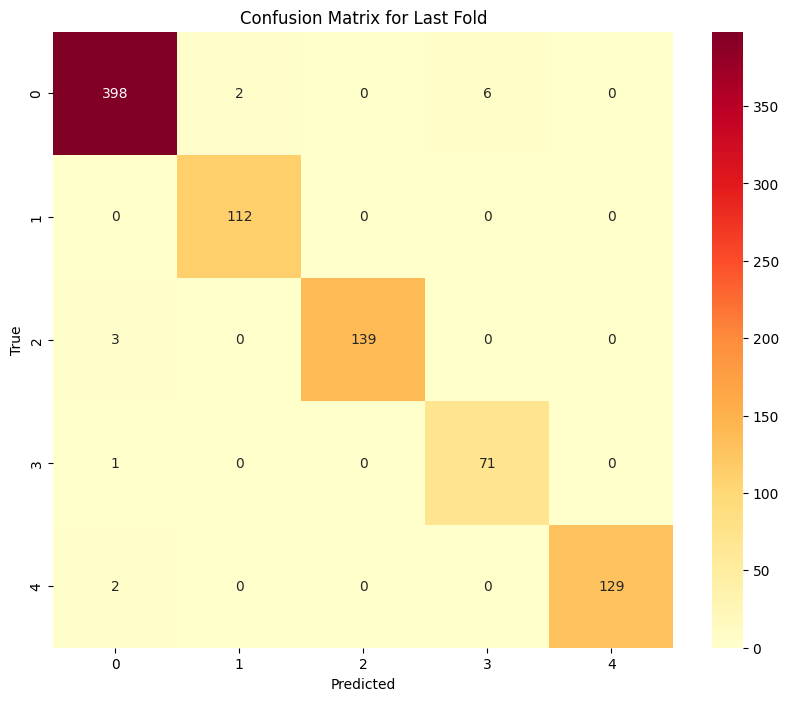

In [32]:
# Confusion Matrix
conf_matrixKF = tf.math.confusion_matrix(y_true_classesKF, y_pred_classesKF)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrixKF, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix for Last Fold')
plt.show()


Label Distribution:
 labels
0    2031
4     687
2     618
1     569
3     414
Name: count, dtype: int64


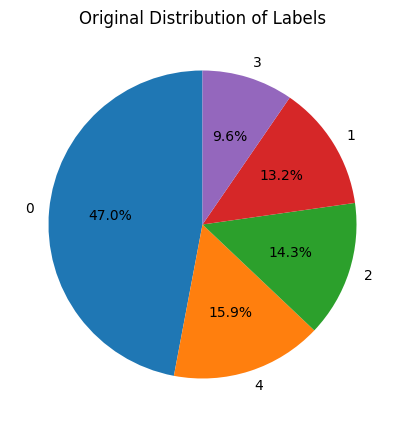

In [33]:
if 'labels' in data.columns:
    label_countsKF = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_countsKF)
    plt.figure(figsize=(5, 5))
    plt.pie(label_countsKF, labels=label_countsKF.index, autopct='%1.1f%%', startangle=90)
    plt.title('Original Distribution of Labels')
    plt.show()

0    404
2    139
4    129
1    114
3     77
Name: count, dtype: int64


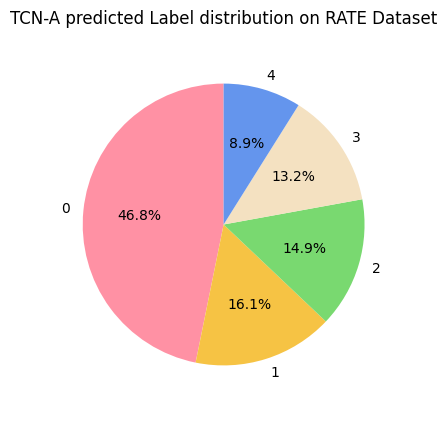

In [34]:

# Get the label distribution after training
# Get the predicted labels after training
class_counts = pd.Series(y_pred_classesKF).value_counts()
print(class_counts)
# Plot pie chart of predicted labels
plt.figure(figsize=(4, 5))
colors = ["#FF91A4", "#f6c344", "#79d970", "#F4E1C1", "#6495ED"]
plt.pie(pd.Series(y_pred_classesKF).value_counts(), labels=label_encoder.classes_, autopct='%1.1f%%', startangle=90,colors=colors)
plt.axis('equal')
plt.title('TCN-A predicted Label distribution on RATE Dataset')
plt.show()

# **SHAP (According to Ma'am)

In [35]:
import shap
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Flatten data for clustering (keeping shape (4319, 16))
X_flat = X_reshaped.reshape(X_reshaped.shape[0], -1)  # (4319, 16)

In [37]:
X_flat.shape

(4319, 16)

In [38]:
X_scaled.shape

(4319, 16)

In [ ]:

# Step 2: Apply KMeans clustering to select representative background data
num_clusters = 20  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)

# Step 3: Select cluster centers as background data
background_data_kmeans = kmeans.cluster_centers_

# Step 4: Define SHAP KernelExplainer (Model-Agnostic)
def model_predict(X):
    X_input = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape back to (N, 1, 16) for TCN
    return modelKF.predict(X_input)

# Step 5: Create KernelExplainer
explainer_kernel = shap.KernelExplainer(model_predict, background_data_kmeans)

# Step 6: Compute SHAP values on a test subset
X_test_sample = X_flat[:]  # Selecting a subset for SHAP analysis
shap_values_kernel = explainer_kernel.shap_values(X_test_sample,silent=True)

# Step 7: Visualize SHAP summary plot
# shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 

In [49]:
X_flat.shape

(4319, 16)

In [50]:
shap_values_kernel

[array([[ 0.07714104,  0.04777177,  0.        , ...,  0.08498864,
          0.        ,  0.        ],
        [ 0.07211329,  0.08110251,  0.        , ...,  0.01610565,
          0.        ,  0.        ],
        [ 0.15199374,  0.11909379,  0.        , ...,  0.03851557,
          0.        ,  0.        ],
        ...,
        [ 0.10382211,  0.27546721,  0.        , ...,  0.03112264,
          0.        ,  0.        ],
        [-0.22180694, -0.21984492,  0.        , ...,  0.00765952,
          0.        ,  0.        ],
        [ 0.10206791,  0.27539916,  0.        , ...,  0.02990115,
          0.        ,  0.        ]]),
 array([[ 0.00661398,  0.0066257 ,  0.        , ...,  0.00296628,
          0.        ,  0.        ],
        [ 0.02617673, -0.02122615,  0.        , ...,  0.01948378,
          0.        ,  0.        ],
        [-0.00692728, -0.00760174,  0.        , ..., -0.00097716,
          0.        ,  0.        ],
        ...,
        [-0.01463851, -0.01284709,  0.        , ...,  

In [51]:
len(shap_values_kernel)

5

In [94]:
shap_values_kernel[0]

array([[ 0.07714104,  0.04777177,  0.        , ...,  0.08498864,
         0.        ,  0.        ],
       [ 0.07211329,  0.08110251,  0.        , ...,  0.01610565,
         0.        ,  0.        ],
       [ 0.15199374,  0.11909379,  0.        , ...,  0.03851557,
         0.        ,  0.        ],
       ...,
       [ 0.10382211,  0.27546721,  0.        , ...,  0.03112264,
         0.        ,  0.        ],
       [-0.22180694, -0.21984492,  0.        , ...,  0.00765952,
         0.        ,  0.        ],
       [ 0.10206791,  0.27539916,  0.        , ...,  0.02990115,
         0.        ,  0.        ]])

In [52]:
shap_values_kernel[0].shape

(4319, 16)

(16,)

array([[ 0.07714104,  0.04777177,  0.        , ...,  0.08498864,
         0.        ,  0.        ],
       [ 0.07211329,  0.08110251,  0.        , ...,  0.01610565,
         0.        ,  0.        ],
       [ 0.15199374,  0.11909379,  0.        , ...,  0.03851557,
         0.        ,  0.        ],
       ...,
       [ 0.10382211,  0.27546721,  0.        , ...,  0.03112264,
         0.        ,  0.        ],
       [-0.22180694, -0.21984492,  0.        , ...,  0.00765952,
         0.        ,  0.        ],
       [ 0.10206791,  0.27539916,  0.        , ...,  0.02990115,
         0.        ,  0.        ]])

In [53]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 0  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the first data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


SHAP values for the first data point:
Feature 0: [0.0771410409554125, 0.04777177426826642, 0.0, 0.1149294625948296, 0.0023129222721911787, -0.0004199803827803528, 0.03304131575658793, 0.0, -0.045790144489669234, 0.09834046650104705, -0.051943417361793205, 0.13546408763294665, 0.05439568025057983, 0.08498863581952376, 0.0, 0.0]
Feature 1: [0.07211329333363692, 0.08110251178274969, 0.0, -0.22794460464331856, -0.005725094777480514, 0.012617094662582646, -0.2682632410725306, 0.0, -0.007984467789304167, -0.035459535857023466, 0.002181429903094152, 0.0042221376228558675, -0.0820001032012342, 0.01610565296126909, 0.0, 0.0]
Feature 2: [0.1519937379348066, 0.1190937855088009, 0.0, 0.04920954587697558, 0.008598297735768576, -0.011663730715934465, 0.05055032731392783, 0.0, 0.12874051114633744, 0.013442420606240993, 0.019192905080153852, 0.06618376329448193, -0.07545224103971046, 0.03851556957153979, 0.0, 0.0]
Feature 3: [-0.21760148702370188, -0.22840040519441407, 0.0, 0.03374937036331921, 0.0242

In [92]:
import numpy as np

# Assuming shap_values_kernel is your (200, 16, 5) SHAP array
data_point_index = 5  # Selecting the first data point
shap_values_single = shap_values_kernel[data_point_index]  # Shape: (16, 5)

# Print nicely
print("SHAP values for the 101th data point:")
for feature_idx, shap_values_per_class in enumerate(shap_values_single):
    print(f"Feature {feature_idx}: {shap_values_per_class.tolist()}")


IndexError: list index out of range

In [177]:
if 'feature_names' not in locals():
    feature_names = [f'feature_{i+1}' for i in range(16)] # Placeholder if you don't have them

if 'class_names' not in locals():
    class_names = ['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly', 'RC Anomaly']

if 'predicted_classes' in locals():
    shap_importance_per_class_list = []
    for class_name in class_names:
        # Get indices of data points predicted as the current class
        class_indices = np.where(predicted_classes == class_name)[0]
        if len(class_indices) > 0:
            # Extract SHAP values for these data points
            shap_values_for_class = shap_values_kernel[class_indices]
            # Calculate mean absolute SHAP value per feature for this class
            mean_abs_shap = np.mean(np.abs(shap_values_for_class), axis=0)
            shap_importance_per_class_list.append(mean_abs_shap)
        else:
            # Handle cases where a class might have no predictions
            shap_importance_per_class_list.append(np.zeros(16)) # Or some other appropriate handling

    shap_importance_per_class = np.array(shap_importance_per_class_list).T # Shape (16, 5)

else:
    # If you don't have predicted classes directly, you need to adapt this
    # based on how your SHAP values relate to the classes.
    print("Warning: 'predicted_classes' not found. Assuming a direct mapping is needed.")
    # This is a placeholder - you need to implement the correct way to get
    # mean absolute SHAP values per feature for each class from your data.
    shap_importance_per_class = np.random.rand(16, 5) # Placeholder with correct shape

# Now create the DataFrame with the correct shape
shap_df = pd.DataFrame(shap_importance_per_class, columns=class_names, index=feature_names)
shap_df_t=shap_df.T

In [178]:
shap_df.columns

Index(['Normal', 'GPS Anomaly', 'Accelerometer Anomaly', 'Engine Anomaly',
       'RC Anomaly'],
      dtype='object')

In [179]:
shap_df_t.columns

Index(['LineNo', 'TimeUS', 'I', 'Status', 'GMS', 'GWk', 'NSats', 'HDop', 'Lat',
       'Lng', 'Alt', 'Spd', 'GCrs', 'VZ', 'Yaw', 'U'],
      dtype='object')

In [180]:
# Remove 'LineNo' and 'abTimeUS' from the index (rows)
shap_df_new= shap_df.drop(index=['LineNo', 'TimeUS'])


In [183]:

# Display top contributing features for each anomaly type
for anomaly_class in shap_df.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
GMS       0.947061
NSats     0.913135
Alt       0.698123
HDop      0.675273
LineNo    0.640913
Status    0.582828
Lng       0.551411
VZ        0.473160
Lat       0.467388
GCrs      0.266700
Spd       0.260086
I         0.208051
TimeUS    0.193509
U         0.152756
Yaw       0.129932
GWk       0.112430
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
Yaw       0.997025
Alt       0.916965
VZ        0.879248
NSats     0.774364
GMS       0.745404
Spd       0.710656
GCrs      0.492273
Status    0.444191
U         0.419889
TimeUS    0.403623
I         0.289652
HDop      0.274664
GWk       0.249681
LineNo    0.154727
Lng       0.140987
Lat       0.065793
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
U         0.954458
TimeUS    0.934016
Alt       0.906965
Lat       0.900120
Yaw       0.796438
NSats     0.670289
LineNo    0.655371
Status    0.601403
GMS       0.46618

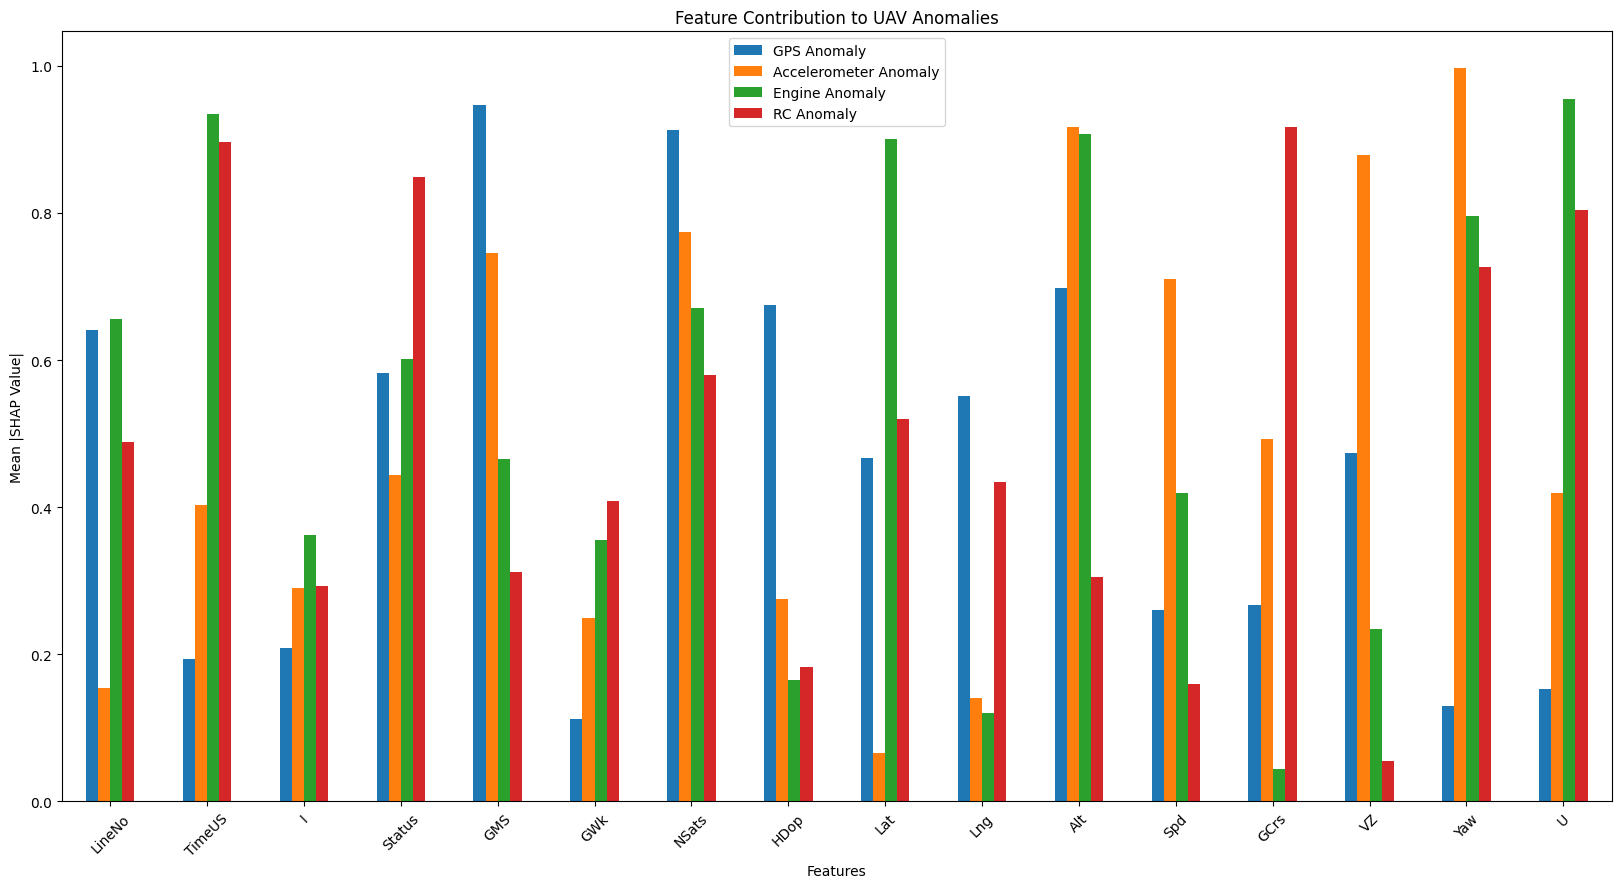

In [184]:
import matplotlib.pyplot as plt

# Plot feature importance for each anomaly type
shap_df.iloc[:, 1:].plot(kind='bar', figsize=(20, 10), title="Feature Contribution to UAV Anomalies")
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
# plt.legend(title="Anomaly Type")
plt.xticks(rotation=45)
plt.show()


In [185]:
feature_names

['LineNo',
 'TimeUS',
 'I',
 'Status',
 'GMS',
 'GWk',
 'NSats',
 'HDop',
 'Lat',
 'Lng',
 'Alt',
 'Spd',
 'GCrs',
 'VZ',
 'Yaw',
 'U']

In [186]:
top_features = shap_df.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)



Most Contributing Feature for Each Anomaly Type:

GPS Anomaly               GMS
Accelerometer Anomaly     Yaw
Engine Anomaly              U
RC Anomaly               GCrs
dtype: object


In [57]:
# import matplotlib.pyplot as plt

# # Assuming shap_values_kernel and feature_names are defined as in your provided code.

# # Select a specific instance (example: index 0) and class to visualize (example: class 1)
# instance_index = 0
# class_index = 1

# # Extract SHAP values for the selected instance and class
# shap_values = shap_values_kernel[instance_index, :, class_index]

# # Create the waterfall plot
# plt.figure(figsize=(10, 6))
# shap.plots.waterfall(shap.Explanation(values=shap_values,
#                                       base_values=explainer_kernel.expected_value[class_index],
#                                       data=X_test_sample[instance_index],
#                                       feature_names=feature_names))
# plt.show()


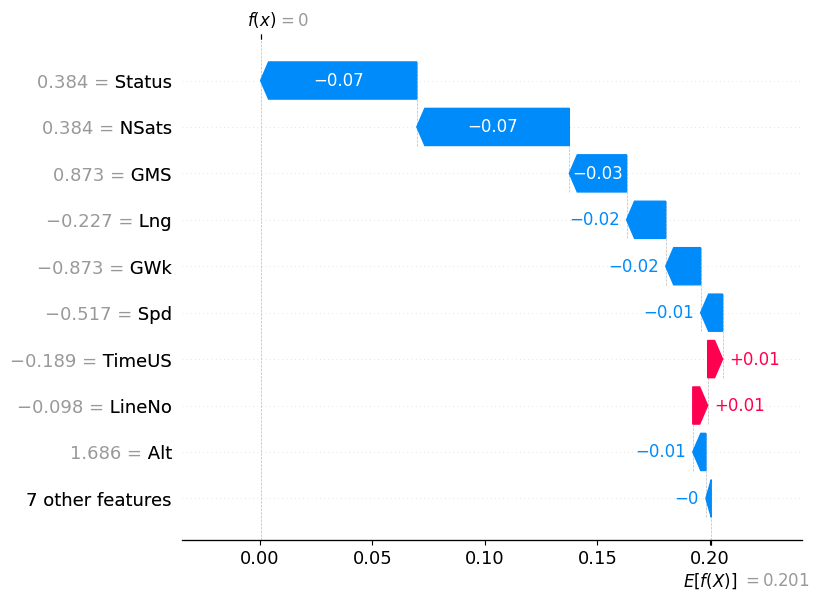

In [187]:

# Select instance and class to visualize
instance_index = 0
class_index = 1

# STEP 1: Handle case when shap_values_kernel is a list (multi-class format)
if isinstance(shap_values_kernel, list):
    # Each element is (n_samples, n_features)
    shap_values_instance = shap_values_kernel[class_index][instance_index]  # shape: (n_features,)
    base_value = explainer_kernel.expected_value[class_index]
else:
    # It's a NumPy array of shape (n_samples, n_features, n_classes)
    shap_values_instance = shap_values_kernel[instance_index, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]

# STEP 2: Build SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_instance,
    base_values=base_value,
    data=X_test_sample[instance_index],
    feature_names=feature_names
)

# STEP 3: Plot the waterfall
shap.plots.waterfall(explanation)


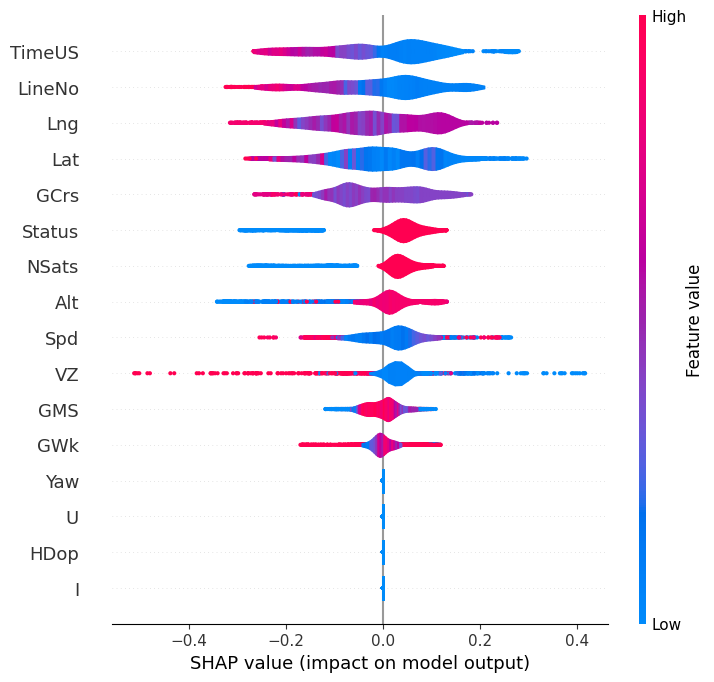

In [188]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 0

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)


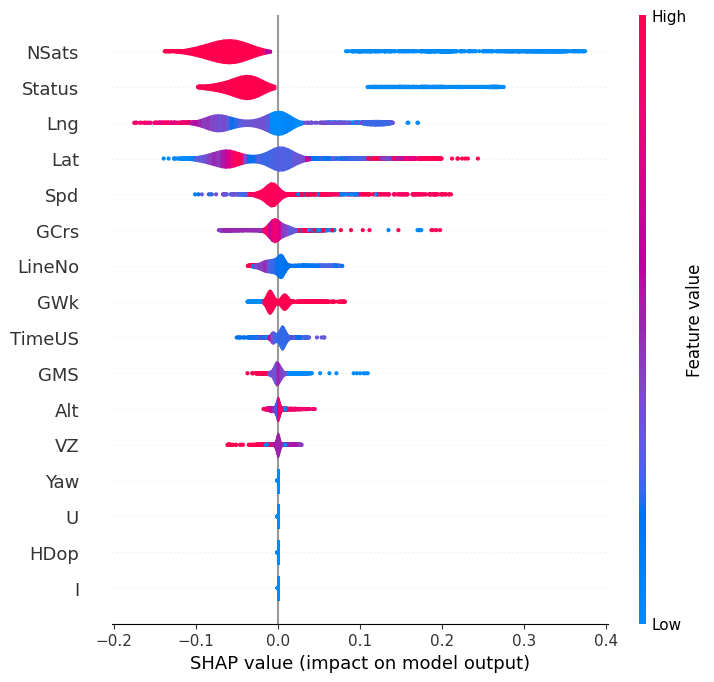

In [189]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 1

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)


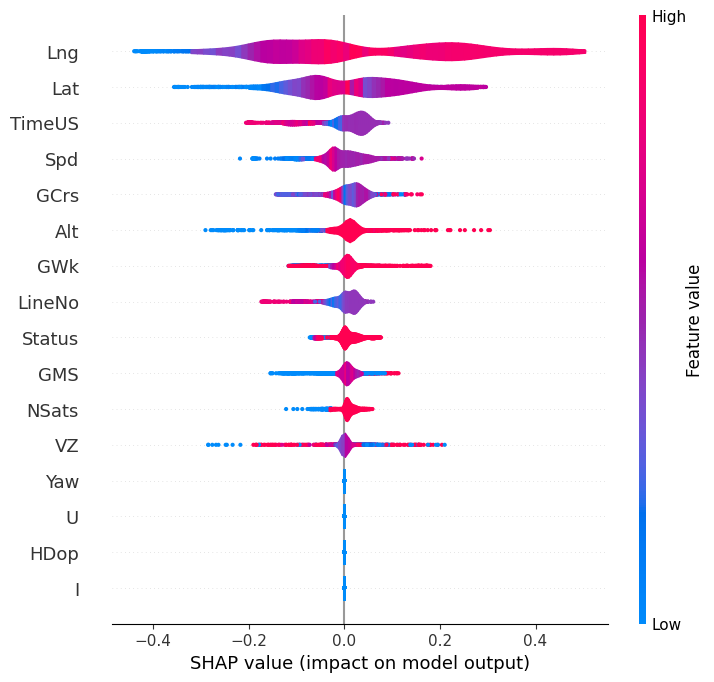

In [190]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 2

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)


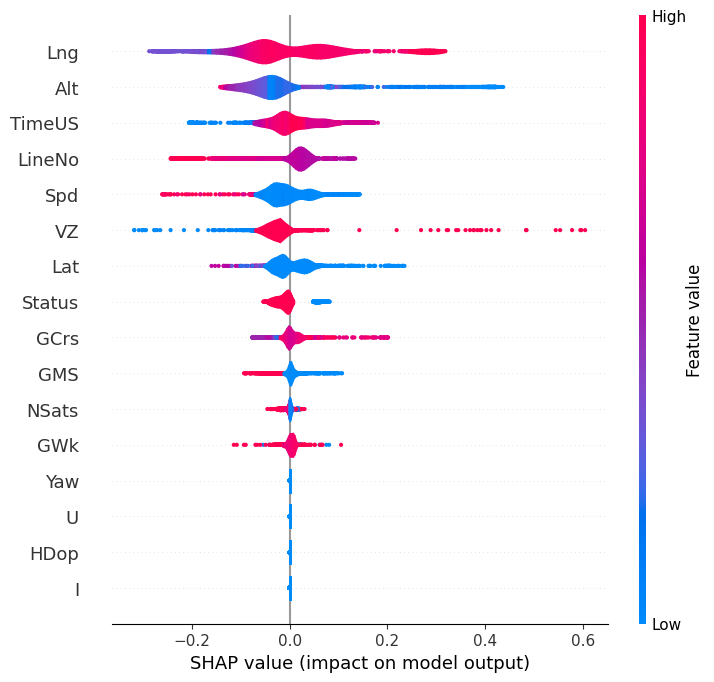

In [191]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 3

# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)


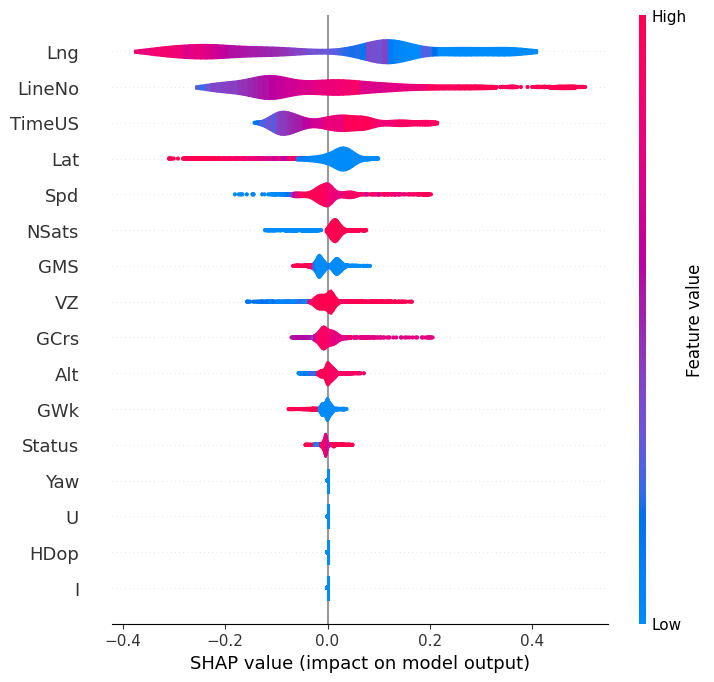

In [192]:
# Choose a specific class index to plot (e.g., class_index = 1)
class_index = 4
# Step 1: Extract SHAP values for that class
# If shap_values_kernel is a NumPy array:
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_single_class,
    base_values=base_value,
    data=X_test_sample,
    feature_names=feature_names
)

# Step 3: Violin plot
shap.plots.violin(explanation)


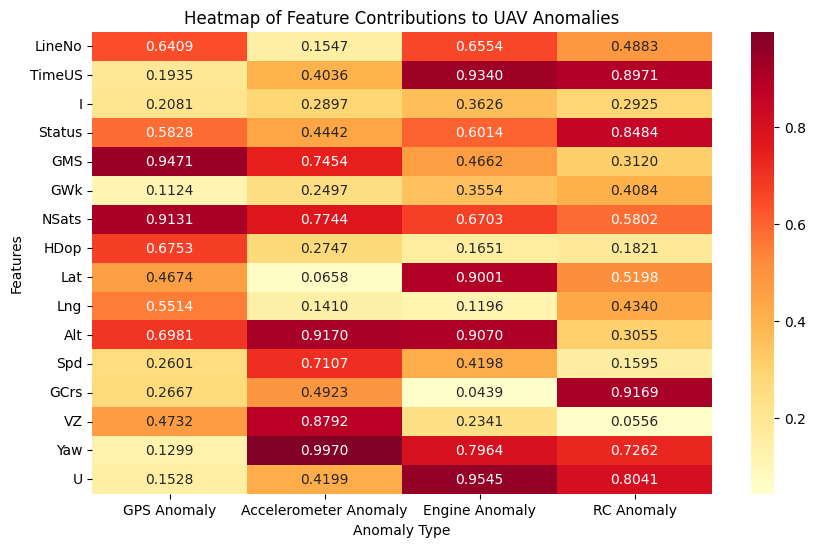

In [193]:
plt.figure(figsize=(10, 6))
sns.heatmap(shap_df.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".4f")
plt.title("Heatmap of Feature Contributions to UAV Anomalies")
plt.xlabel("Anomaly Type")
plt.ylabel("Features")
plt.show()


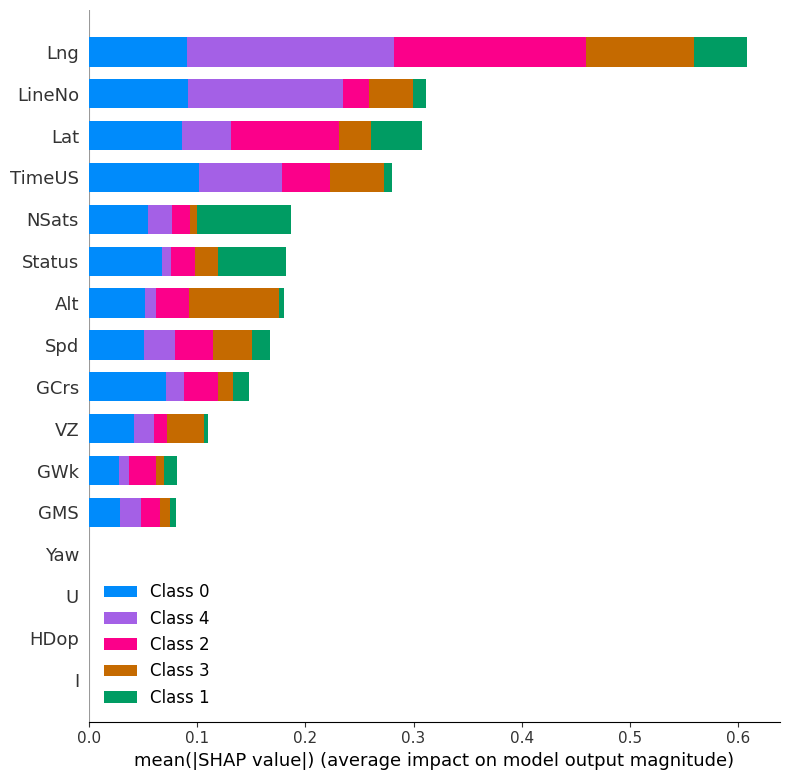

In [194]:
shap.summary_plot(shap_values_kernel, X_test_sample, feature_names=feature_names)

# Without TimeUs and LineNo


In [198]:
for anomaly_class in shap_df_new.columns[1:]: # Skip 'Normal'
    print(f"\nTop Contributing Features for {anomaly_class}:")
    print(shap_df_new[anomaly_class].sort_values(ascending=False))


Top Contributing Features for GPS Anomaly:
GMS       0.947061
NSats     0.913135
Alt       0.698123
HDop      0.675273
Status    0.582828
Lng       0.551411
VZ        0.473160
Lat       0.467388
GCrs      0.266700
Spd       0.260086
I         0.208051
U         0.152756
Yaw       0.129932
GWk       0.112430
Name: GPS Anomaly, dtype: float64

Top Contributing Features for Accelerometer Anomaly:
Yaw       0.997025
Alt       0.916965
VZ        0.879248
NSats     0.774364
GMS       0.745404
Spd       0.710656
GCrs      0.492273
Status    0.444191
U         0.419889
I         0.289652
HDop      0.274664
GWk       0.249681
Lng       0.140987
Lat       0.065793
Name: Accelerometer Anomaly, dtype: float64

Top Contributing Features for Engine Anomaly:
U         0.954458
Alt       0.906965
Lat       0.900120
Yaw       0.796438
NSats     0.670289
Status    0.601403
GMS       0.466189
Spd       0.419756
I         0.362632
GWk       0.355363
VZ        0.234087
HDop      0.165088
Lng       0.11959

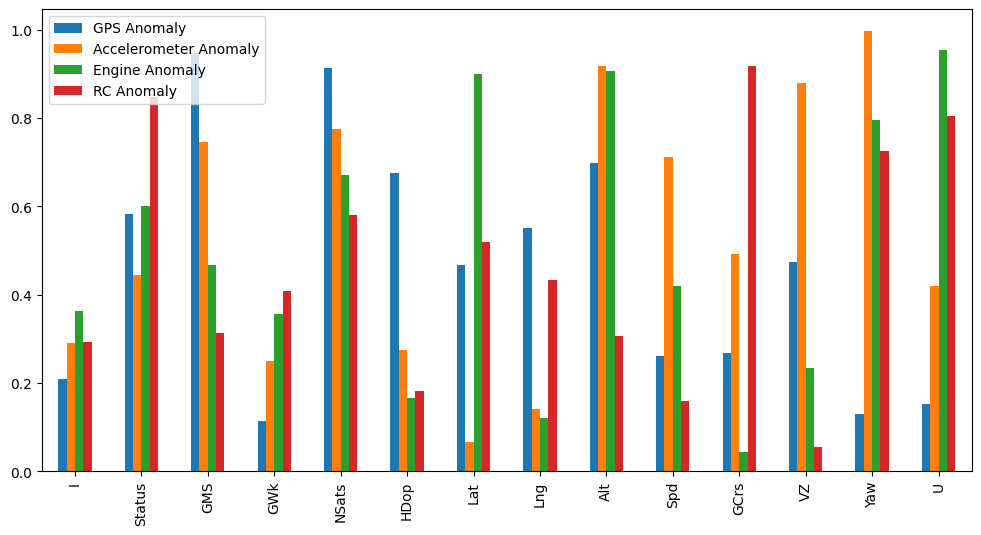

In [199]:
shap_df_new.iloc[:,1:].plot(kind="bar",figsize=(12,6))
plt.show()

In [200]:
top_features = shap_df_new.iloc[:, 1:].idxmax()
print("\nMost Contributing Feature for Each Anomaly Type:\n")
print(top_features)


Most Contributing Feature for Each Anomaly Type:

GPS Anomaly               GMS
Accelerometer Anomaly     Yaw
Engine Anomaly              U
RC Anomaly               GCrs
dtype: object


In [210]:
len(shap_values_kernel) #( 4319,16,5)

5

In [214]:
shap_values_kernel[0].shape

(4319, 16)

In [216]:
shap_values_kernel[1][0]

array([ 0.00661398,  0.0066257 ,  0.        , -0.06937973, -0.0254249 ,
       -0.01551502, -0.06773646,  0.        , -0.00090433, -0.0173906 ,
       -0.00583469, -0.00974865, -0.00440832,  0.00296628,  0.        ,
        0.        ])

Plot to display the feature contribution for any given anomaly(0-4) and any give feature (0-4319)

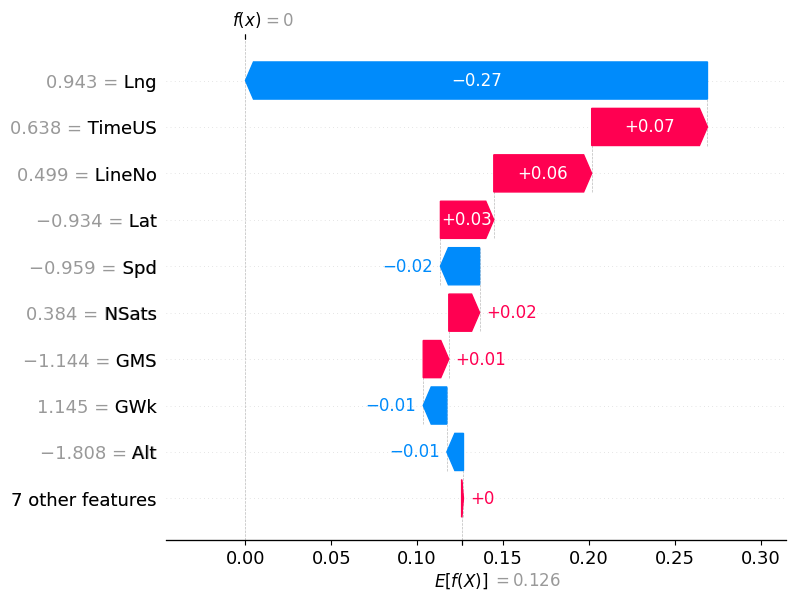

In [224]:

# Select instance and class to visualize
instance_index = 4312
class_index = 4

# STEP 1: Handle case when shap_values_kernel is a list (multi-class format)
if isinstance(shap_values_kernel, list):
    # Each element is (n_samples, n_features)
    shap_values_instance = shap_values_kernel[class_index][instance_index]  # shape: (n_features,)
    base_value = explainer_kernel.expected_value[class_index]
else:
    # It's a NumPy array of shape (n_samples, n_features, n_classes)
    shap_values_instance = shap_values_kernel[instance_index, :, class_index]
    base_value = explainer_kernel.expected_value[class_index]

# STEP 2: Build SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values_instance,
    base_values=base_value,
    data=X_test_sample[instance_index],
    feature_names=feature_names
)

# STEP 3: Plot the waterfall
shap.plots.waterfall(explanation)


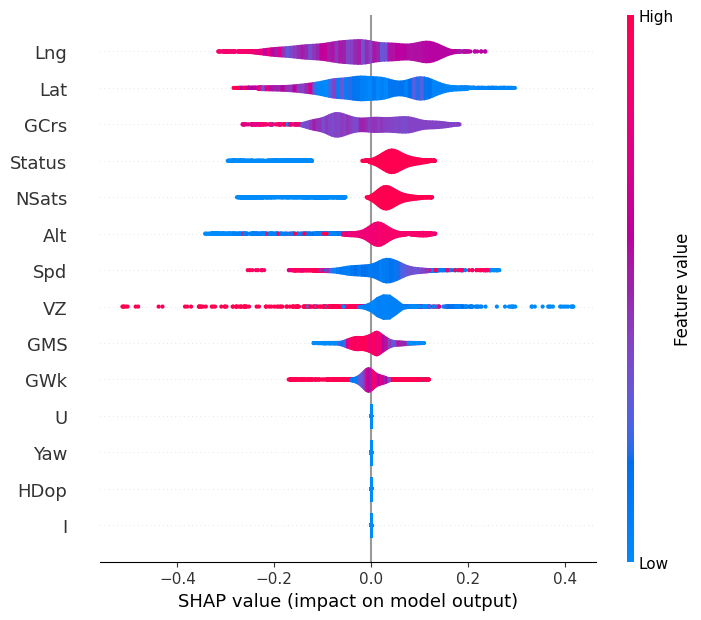

In [202]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 0

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


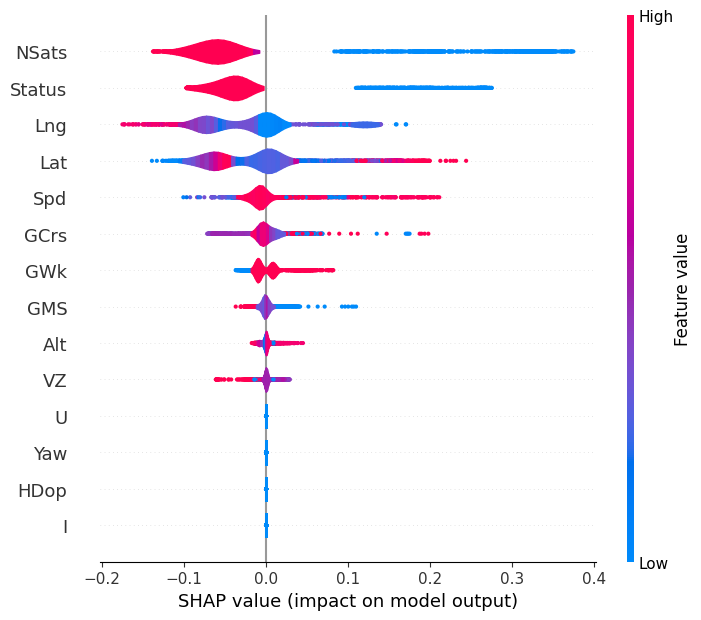

In [203]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 1

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


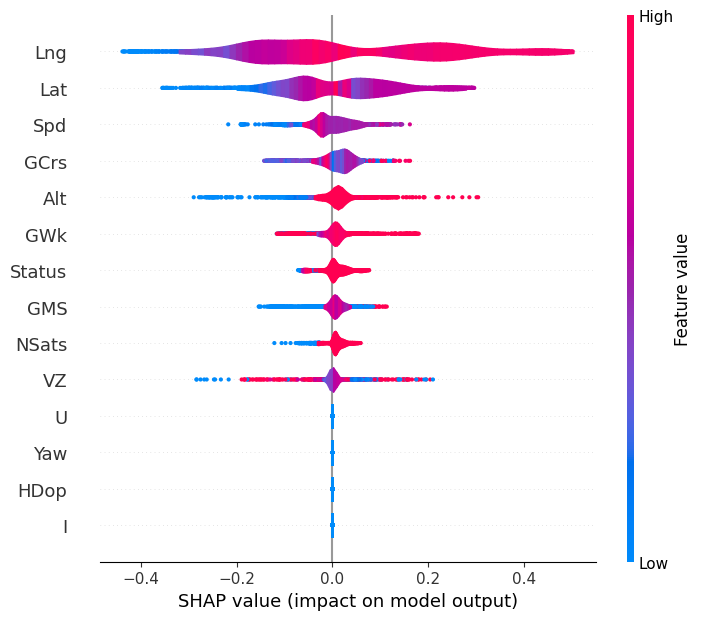

In [204]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 2

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


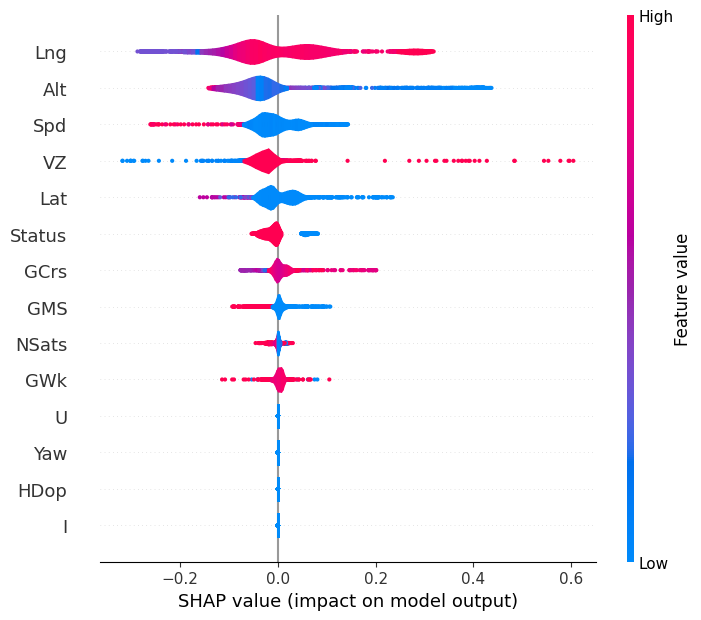

In [205]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 3

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


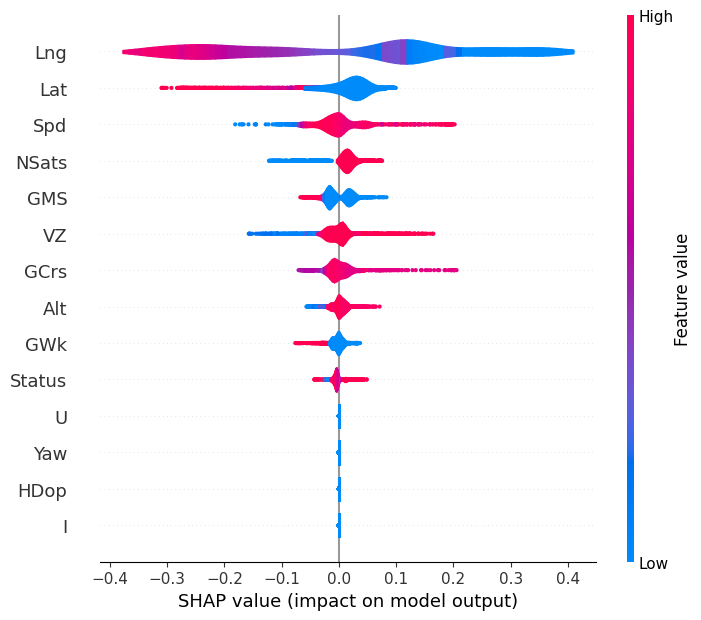

In [206]:
# For Normal/ No Anomaly

# Choose a specific class index to plot (e.g., class_index = 0)
class_index = 4

# Step 1: Extract SHAP values for that class
if isinstance(shap_values_kernel, np.ndarray):
    shap_values_single_class = shap_values_kernel[:, :, class_index]  # shape: (n_samples, n_features)
    base_value = explainer_kernel.expected_value[class_index]
else:  # If it's a list
    shap_values_single_class = shap_values_kernel[class_index]
    base_value = explainer_kernel.expected_value[class_index]

# Step 2: Create SHAP DataFrame to filter unwanted features
shap_df = pd.DataFrame(
    shap_values_single_class,
    columns=feature_names
)
data_df = pd.DataFrame(
    X_test_sample,
    columns=feature_names
)

# Step 3: Drop unwanted features
features_to_drop = ['LineNo', 'TimeUS']
shap_filtered = shap_df.drop(columns=features_to_drop, errors='ignore')
data_filtered = data_df.drop(columns=features_to_drop, errors='ignore')

# Step 4: Create SHAP Explanation object with filtered data
explanation = shap.Explanation(
    values=shap_filtered.values,
    base_values=np.full(shape=(shap_filtered.shape[0],), fill_value=base_value),
    data=data_filtered.values,
    feature_names=shap_filtered.columns.tolist()
)

# Step 5: Violin plot
shap.plots.violin(explanation)


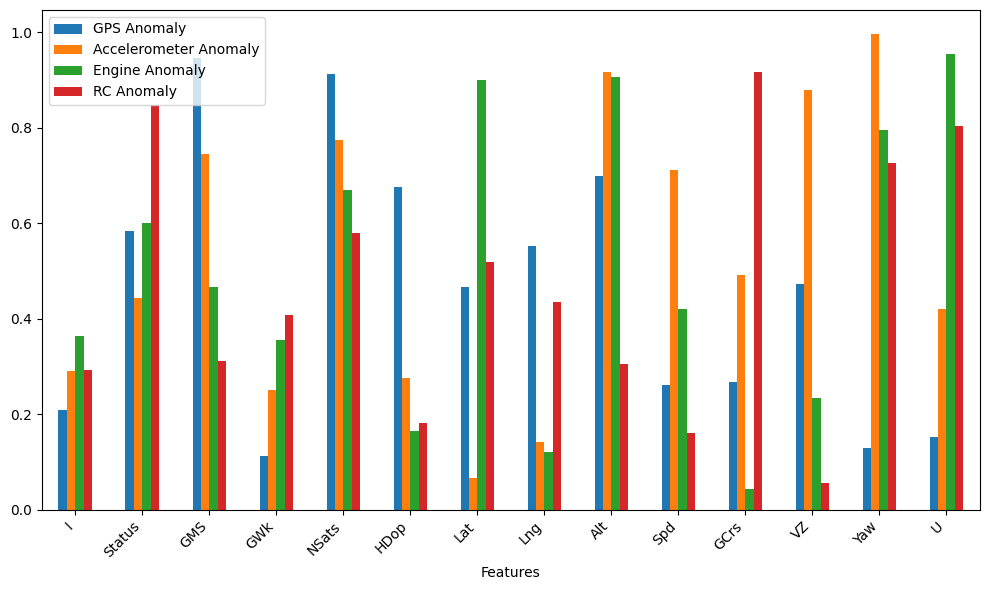

In [207]:
plt.figure(figsize=(10, 6))
shap_df_new.iloc[:, 1:].plot(kind='bar', ax=plt.gca())
# plt.title("Feature Contribution to UAV Anomalies (Excluding LineNo and abTimeUs)")
plt.xlabel("Features")
# plt.ylabel("Mean |SHAP Value|")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

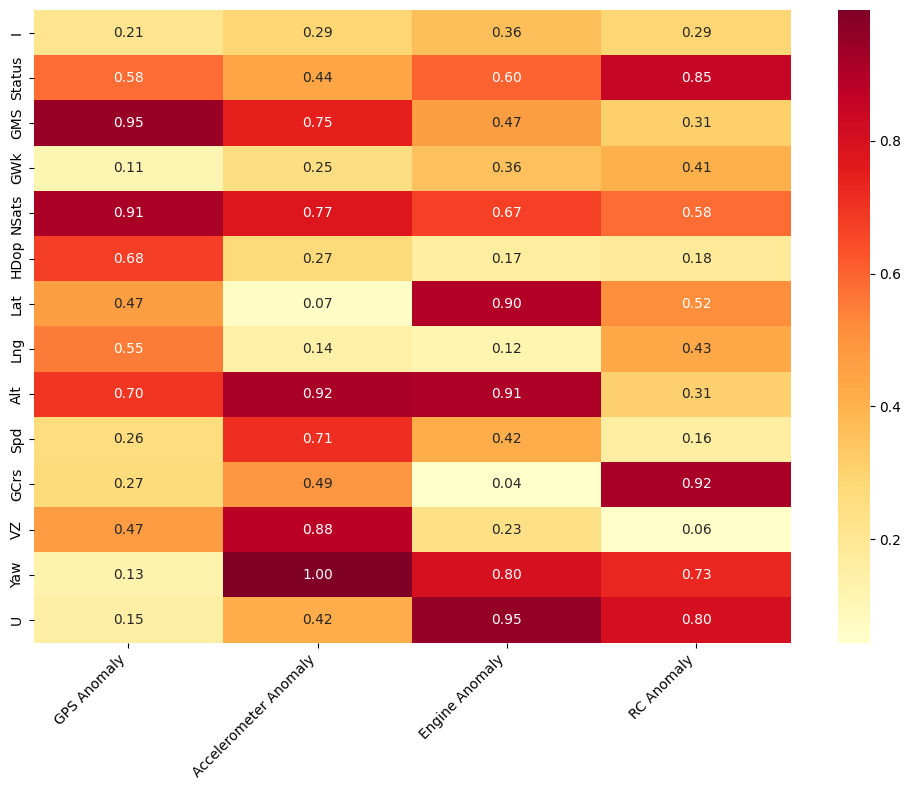

In [208]:
plt.figure(figsize=(10, 8))
sns.heatmap(shap_df_new.iloc[:, 1:], annot=True, cmap="YlOrRd", fmt=".2f")
# plt.title("Feature Contribution Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

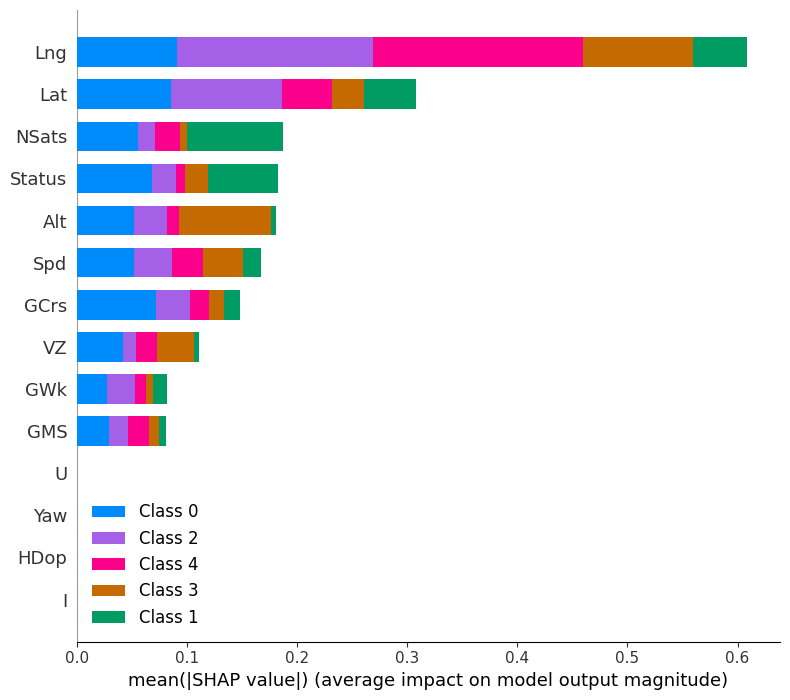

In [225]:
# List of features to exclude
exclude_features = ['LineNo', 'TimeUS']

# Step 1: Convert X_test_sample to DataFrame (if it's not already)
X_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Step 2: Drop excluded features
X_filtered = X_df.drop(columns=exclude_features, errors='ignore')
filtered_feature_names = X_filtered.columns.tolist()

# Step 3: Drop the corresponding SHAP values
# For multi-class (list of arrays), handle each class separately
if isinstance(shap_values_kernel, list):
    shap_values_filtered = []
    for class_values in shap_values_kernel:
        class_df = pd.DataFrame(class_values, columns=feature_names)
        shap_filtered = class_df.drop(columns=exclude_features, errors='ignore')
        shap_values_filtered.append(shap_filtered.values)
else:
    # shap_values_kernel shape: (n_samples, n_features, n_classes)
    feature_indices = [i for i, f in enumerate(feature_names) if f not in exclude_features]
    shap_values_filtered = shap_values_kernel[:, feature_indices, :]

# Step 4: Plot
shap.summary_plot(shap_values_filtered, X_filtered.values, feature_names=filtered_feature_names)
